In [1]:
# import libraries
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
from shapely import wkt
import itertools
from street_features import *

# Importing Randomly Created Coordinates data for Feature Engineering

## Open Street Maps

In [2]:
## Import Seattle street and map data
Seattle_poly = ox.gdf_from_place('Seattle, Washington')

# grab street data (roads and intersections) for entire city
sea_streets = ox.graph_from_place('Seattle, Washington', network_type = 'drive')
nodes, edges = ox.graph_to_gdfs(sea_streets)

In [3]:
#remove doubled road IDs, this is only 20 roads out of 22335, but they cause subsetting problems
sea_rds = remove_doubleID_streets(edges)

# grab subsets of roadtypes
sea_highways = sea_rds[sea_rds.highway == 'motorway']
sea_primary = sea_rds[sea_rds.highway == 'primary']
sea_secondary = sea_rds[sea_rds.highway == 'secondary']
sea_resid = sea_rds[sea_rds.highway == 'residential']

## Convert data to Geopandas frame and Subset on Seattle polygon grid

In [36]:
## Import walk_score data, create shapely points, and convert to geopandas dataframe
walk_df = pd.read_csv('Data/master_walk_score.csv', index_col=0)




geometry = [Point(xy) for xy in zip(walk_df.lon, walk_df.lat)]
walk_gdf = gpd.GeoDataFrame(walk_df, geometry=geometry, crs={'init' :'epsg:4326'})


#subset walk_score data in Seattle polygon grid
EDF_points = gpd.sjoin(walk_gdf, Seattle_poly, how="inner", op="intersects")
EDF_points = EDF_points.rename(index=str)

EDF_points = EDF_points.reset_index(drop=True)
EDF_points = EDF_points.drop(['index_right', 'bbox_east', 'bbox_north', 'bbox_south', 'bbox_west'], axis=1)
EDF_points.head(3)

,lat,lon,walk_score,geometry,place_name
0,47.693792,-122.312816,67,POINT (-122.3128161896134 47.69379169576278),"Seattle, King County, Washington, USA"
1,47.673859,-122.341078,35,POINT (-122.3410775145169 47.67385884412313),"Seattle, King County, Washington, USA"
2,47.693318,-122.338032,63,POINT (-122.3380317656147 47.69331844878893),"Seattle, King County, Washington, USA"


## Census data

In [5]:
# Import Census data
WA_tracts = pd.read_csv('Data/all_demographics.csv') 
WA_tracts['geometry'] = WA_tracts['geometry'].apply(wkt.loads)
WA_tracts = gpd.GeoDataFrame(WA_tracts, geometry = WA_tracts['geometry'], crs={'init' :'epsg:2927'})
WA_tracts = WA_tracts.drop(['Unnamed: 0'], axis = 1)

In [6]:
WA_tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 18 columns):
GEOID10       398 non-null int64
POP10         398 non-null int64
ALANDMI       398 non-null float64
OBJECTID      398 non-null int64
STATEFP10     398 non-null int64
COUNTYFP10    398 non-null int64
TRACTCE10     398 non-null int64
NAME10        398 non-null float64
NAMELSAD10    398 non-null object
MTFCC10       398 non-null object
FUNCSTAT10    398 non-null object
ALAND10       398 non-null float64
AWATER10      398 non-null float64
INTPTLAT10    398 non-null float64
INTPTLON10    398 non-null float64
Shape_Leng    398 non-null float64
Shape_Area    398 non-null float64
geometry      398 non-null object
dtypes: float64(8), int64(6), object(4)
memory usage: 56.0+ KB


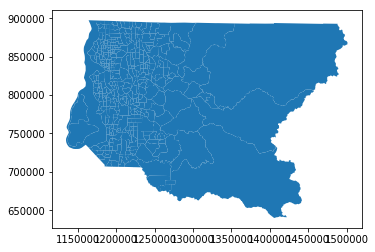

In [7]:
WA_tracts.plot()

In [8]:
# drop extraneous columns and rename census variables
extra_cols = ['STATEFP10', 'COUNTYFP10', 'ALAND10', 'AWATER10', 'TRACTCE10', 'NAMELSAD10', 'MTFCC10', 'FUNCSTAT10', 
             'INTPTLAT10', 'INTPTLON10', 'OBJECTID', 'Shape_Leng', 'Shape_Area', 'geometry']

WA_tracts = WA_tracts.drop(extra_cols, axis=1)
WA_tracts = WA_tracts.rename(index=str, columns = {'GEOID10': 'GEOID','POP10': 'population', 'NAME10': 'tract', 
                                                   'ALANDMI': 'Area in Land Miles'})

# calculate area and population density

WA_tracts['pop_den'] = WA_tracts['population'] / WA_tracts['Area in Land Miles']

WA_tracts['pop_den'] = WA_tracts['pop_den'].fillna(0)

WA_tracts.head(3)

,GEOID,population,Area in Land Miles,tract,pop_den
0,53033000100,6255,0.738,1.0,8475.609756
1,53033000200,7646,1.269,2.0,6025.216706
2,53033000300,2603,0.467,3.0,5573.875803


## Seattle Zoning Data

In [9]:
## import zoning data
sea_zones = gpd.read_file('/Users/perryjohnson/Desktop/Walkability/Data/Zoning_Detailed/Zoning_Detailed.shp')

print('Seattle Zoning Default CRS:', sea_zones.crs)

# drop extraneous columns
extra_cols = ['OVERLAY', 'CONTRACT', 'OBJECTID', 'ORDINANCE', 'EFFECTIVE', 'HISTORIC', 'SHORELINE', 'PEDESTRIAN',
              'MHA', 'MHA_VALUE', 'OVERLAY_PR', 'LIGHTRAIL', 'ZONELUT_DE', 'LIGHTRAIL_',
             'EFFECTIVE_', 'PEDESTRI_1', 'SHORELINE_', 'MIO_NAME', 'IZ',
             'ZONING_PRE', 'CONTRACT_P', 'HISTORIC_P', 'SHAPE_Leng', 'ORDINANCE_', 'ZONING_DES', 
             'BZONEID', 'DETAIL_DES', 'CATEGORY_D', 'ZONELUT', 'ZONING', 'BASE_ZONE', 'SHAPE_Area']

sea_zones = sea_zones.drop(extra_cols, axis = 1)

## remove null polygons (causes issues with merges)
sea_zones.shape
sea_zones = sea_zones[sea_zones.geometry.notnull()]

sea_zones.head(3)

Seattle Zoning Default CRS: {'init': 'epsg:4326'}


,ZONEID,CLASS_DESC,geometry
0,2985,Downtown,"POLYGON ((-122.3360890199357 47.6002610850185,..."
1,3792,Downtown,POLYGON ((-122.3259675488259 47.59453372968536...
2,3304,Major Institutions,POLYGON ((-122.2959369227568 47.65522891516646...


In [10]:
sea_zones['CLASS_DESC'].value_counts()

Commercial/Mixed Use        1262
Multi-Family                1243
Single Family                434
Major Institutions           287
Manufacturing/Industrial     220
Downtown                      97
Master Planned Community       2
Name: CLASS_DESC, dtype: int64

In [11]:
# lots of zoning information that needs to be cleaned into distinct groups
# Groups: commercial, industrial, residential

sea_zones['zone'] = sea_zones['CLASS_DESC']

## zoning designations to be generalized across the Bay Area
residential = ['Multi-Family', 'Single Family', 'Master Planned Community']
commercial = ['Commercial/Mixed Use', 'Downtown']
industrial = ['Major Institutions', 'Manufacturing/Industrial']


## simplify down to the above zoning designations
sea_zones['zone'] = sea_zones['zone'].replace(dict.fromkeys(residential, 'residential'))
sea_zones['zone'] = sea_zones['zone'].replace(dict.fromkeys(commercial, 'commercial'))
sea_zones['zone'] = sea_zones['zone'].replace(dict.fromkeys(industrial, 'industrial'))

print(sea_zones['zone'].unique())

['commercial' 'industrial' 'residential']


## Road Distance Features

In [12]:
#calculate closest road_type for each point within 300 meter buffer
EDF_points['road_type'] = EDF_points['geometry'].apply(find_closest_road, 
                                                       roads = sea_rds, buffer_dist = 0.0030)

In [13]:
## Calculate distance to nearest major roadway

# much faster to do the re-projection to meters outside of the apply function
EDF_utm = EDF_points.to_crs({'init': 'epsg:32610'}).copy()
highway_utm = sea_highways.to_crs({'init': 'epsg:32610'}).copy()
primary_utm = sea_primary.to_crs({'init': 'epsg:32610'}).copy()
secondary_utm = sea_secondary.to_crs({'init': 'epsg:32610'}).copy()

EDF_points['closest_highway'] = EDF_utm['geometry'].apply(distance_to_roadway, roadway = highway_utm)
EDF_points['closest_primary'] = EDF_utm['geometry'].apply(distance_to_roadway, roadway = primary_utm)
EDF_points['closest_secondary'] = EDF_utm['geometry'].apply(distance_to_roadway, roadway = secondary_utm)

In [14]:
## Calculate distance to nearest intersection and traffic signals
nodes_utm = nodes.to_crs({'init': 'epsg:32610'}).copy() #re-project as above
signals = nodes_utm[nodes_utm['highway'] == 'traffic_signals']

EDF_points['corner_dist'] = EDF_utm['geometry'].apply(nearest_intersection,
                                                            intersections = nodes_utm['geometry'])

EDF_points['signal_dist'] = EDF_utm['geometry'].apply(nearest_intersection, 
                                                               intersections = signals['geometry'])

In [15]:
# Cleaning road categories ...
EDF_points['road_type'] = EDF_points['road_type'].str.replace('_link', '')
EDF_points['road_type'] = np.where(EDF_points['road_type'] == 'trunk', 'secondary', EDF_points['road_type'])
EDF_points['road_type'] = np.where(EDF_points['road_type'] == 'living_street', 'residential', EDF_points['road_type'])
EDF_points['road_type'] = np.where(EDF_points['road_type'] == 'a', 'unclassified', EDF_points['road_type'])
EDF_points['road_type'] = np.where(EDF_points['road_type'] == 'razed', 'unclassified', EDF_points['road_type'])


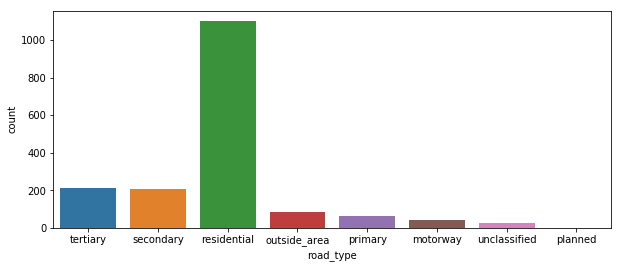

In [16]:
# Road Type Categories
plt.figure(figsize=(10,4))
sns.countplot(EDF_points['road_type']);

## Census and Zoning Features

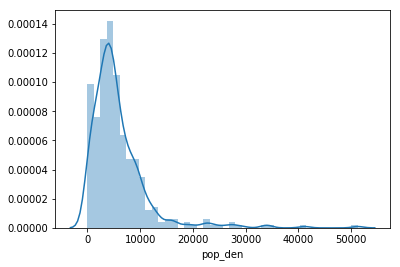

In [17]:
# population densities by census tract in King County
sns.distplot(WA_tracts['pop_den']);

In [18]:
# left merge with the zoning data
walk_all = gpd.sjoin(EDF_points, sea_zones, how='left', op='intersects')


# drop all observations that don't have a zone (thus aren't truly a part of Seattle or are perhaps in the water)
walk_all = walk_all.dropna()

# reset index from dropped null observations
walk_all = walk_all.reset_index(drop=True)

# remove unneeded columsn
walk_all = walk_all.drop(['index_right', 'CLASS_DESC', 'ZONEID'], axis = 1)


walk_all.head(3)

,bus_station_count,lat,lon,park_count,restaurant_count,school_count,supermarket_count,walk_score,pub_count,parkwide_count,...,restaurantwide_count,geometry,place_name,road_type,closest_highway,closest_primary,closest_secondary,corner_dist,signal_dist,zone
0,5,47.558532,-122.399363,5,22,2,0,41,2,34,...,29,POINT (-122.3993628380088 47.55853164856877),"Seattle, King County, Washington, USA",tertiary,1885.270556,1346.558863,172.243515,79.404561,946.785128,residential
1,4,47.584185,-122.403673,3,14,1,0,35,1,21,...,25,POINT (-122.4036728313316 47.58418500735632),"Seattle, King County, Washington, USA",secondary,2789.962129,1330.359218,202.648269,207.181855,1330.359218,residential
2,4,47.579075,-122.412441,4,14,1,0,65,1,20,...,15,POINT (-122.4124409242209 47.57907530454256),"Seattle, King County, Washington, USA",secondary,3137.711062,1962.229345,49.455709,51.739862,1940.736890,commercial


In [19]:
#merge with the census data on GEOID
walk_all = pd.merge(walk_all, WA_tracts, on='GEOID')
walk_all.head(1)

,bus_station_count,lat,lon,park_count,restaurant_count,school_count,supermarket_count,walk_score,pub_count,parkwide_count,...,closest_highway,closest_primary,closest_secondary,corner_dist,signal_dist,zone,population,Area in Land Miles,tract,pop_den
0,5,47.558532,-122.399363,5,22,2,0,41,2,34,...,1885.270556,1346.558863,172.243515,79.404561,946.785128,residential,5290,0.717,97.01,7377.963738


In [20]:
## Calculate distance to industrial zone
#re-projections
walk_utm = walk_all.to_crs({'init': 'epsg:32610'}).copy()
zones_utm = sea_zones.to_crs({'init': 'epsg:32610'}).copy()
industry = zones_utm[zones_utm.zone == 'industrial']
commercial = zones_utm[zones_utm.zone == 'commercial']
residential = zones_utm[zones_utm.zone == 'residential']

#calculations
walk_all['industry_dist'] = walk_utm['geometry'].apply(distance_to_zoning, zone = industry)
walk_all['commercial_dist'] = walk_utm['geometry'].apply(distance_to_zoning, zone = commercial)
walk_all['residential_dist'] = walk_utm['geometry'].apply(distance_to_zoning, zone = residential)

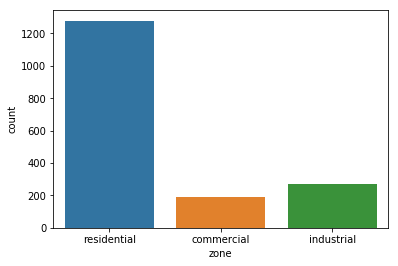

In [21]:
sns.countplot(walk_all['zone'])

# Amenity Features

1) Count of Schools within 1000 meter radius

2) Count of Parks within 1000 meter radius

3) Count of Restaurants within 1000 meter radius

4) Count of Supermarkets within 1000 meter radius

5) Count of Pubs within 1000 meter radius

6) Count of Bus Stations within 10000 meter radius

7) Count of Parks within 2500 meter radius

8) Count of Restaurants within 1500 meter radius

In [22]:
private_token = APIKEY

def location_api(df, amenity, radius, apikey):
    amenity_count = [] 
    for i in range(len(df)):
        count = 0    
        url = 'https://us1.locationiq.com/v1/nearby.php?key='+apikey+'&lat='+str(df['lat'][i])+'&lon='+str(df['lon'][i])+'&tag='+amenity+'&radius='+radius+'&format=json'
        r = requests.get(url)
        data = r.json()
        if 'error' in data:
            amenity_count.append(0)
            print(data)
            time.sleep(0.75)
        else:   
            count = len(data)
            print(count)
            print(i)
            amenity_count.append(count)
            time.sleep(0.75)

    df[amenity+'wide_count'] = amenity_count
    
    return df

In [23]:
#locationiq amenity specs
amenity_specs = [['restaurant', '1000'], ['school', '1000'], ['park', '1000'], 
             ['bus_station', '10000'], ['supermarket', '1000'], ['pub', '1000'],
                ['parkwide', '2500'], ['restaurantwide', '1500']]

walk_all = location_api(walk_all, 'restaurant', '1000', private_token);
walk_all = location_api(walk_all, 'school', '1000', private_token);
walk_all = location_api(walk_all, 'park', '1000', private_token);
walk_all = location_api(walk_all, 'bus_station', '10000', private_token);
walk_all = location_api(walk_all, 'supermarket', '1000', private_token);
walk_all = location_api(walk_all, 'pub', '1000', private_token);
walk_all = location_api(walk_all, 'parkwide', '2500', private_token);
walk_all = location_api(walk_all, 'restaurantwide', '1500', private_token);

"#locationiq amenity specs\namenity_specs = [['restaurant', '1000'], ['school', '1000'], ['park', '1000'], \n             ['bus_station', '10000'], ['supermarket', '1000'], ['pub', '1000'],\n                ['parkwide', '2500'], ['restaurantwide', '1500']]\n\nwalk_all = location_api(walk_all, 'restaurant', '1000', private_token);\nwalk_all = location_api(walk_all, 'school', '1000', private_token);\nwalk_all = location_api(walk_all, 'park', '1000', private_token);\nwalk_all = location_api(walk_all, 'bus_station', '10000', private_token);\nwalk_all = location_api(walk_all, 'supermarket', '1000', private_token);\nwalk_all = location_api(walk_all, 'pub', '1000', private_token);\nwalk_all = location_api(walk_all, 'parkwide', '2500', private_token);\nwalk_all = location_api(walk_all, 'restaurantwide', '1500', private_token);"

In [24]:
walk_all.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1741 entries, 0 to 1740
Data columns (total 28 columns):
bus_station_count       1741 non-null int64
lat                     1741 non-null float64
lon                     1741 non-null float64
park_count              1741 non-null int64
restaurant_count        1741 non-null int64
school_count            1741 non-null int64
supermarket_count       1741 non-null int64
walk_score              1741 non-null int64
pub_count               1741 non-null int64
parkwide_count          1741 non-null int64
GEOID                   1741 non-null int64
restaurantwide_count    1741 non-null int64
geometry                1741 non-null object
place_name              1741 non-null object
road_type               1741 non-null object
closest_highway         1741 non-null float64
closest_primary         1741 non-null float64
closest_secondary       1741 non-null float64
corner_dist             1741 non-null float64
signal_dist             1741 non-n

In [25]:
# find the additional amenities outside of the inital search radius
walk_all['restaurantdiff_count'] = walk_all['restaurantwide_count'] - walk_all['restaurant_count']
walk_all['parkdiff_count'] = walk_all['parkwide_count'] - walk_all['park_count']

## Model Development

In [26]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

In [27]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', color='black')

def pred_summary(pred, ytest, limit = 100):
    """Plotting for test set predictions"""
    sns.scatterplot(pred, ytest)
    abline(1, 0) #1-1 line
    plt.ylim(0, limit); plt.xlim(0, limit)
    plt.tick_params(labelsize=18)
    
    print('RMSE', np.sqrt(mean_squared_error(ytest, pred)))
    print('R2', r2_score(ytest, pred))

In [28]:
walk_model = walk_all.dropna() # remove the few NA values if there are any

# Grab relevant features
X_vars = ['closest_highway', 'closest_primary', 'closest_secondary', 'corner_dist', 'signal_dist', 'zone', 'road_type',
          'industry_dist', 'commercial_dist', 'residential_dist', 'school_count', 'park_count', 'restaurant_count',
         'bus_station_count', 'supermarket_count', 'pub_count', 'parkdiff_count', 'Area in Land Miles', 'population',
         'pop_den', 'restaurantdiff_count']

X = walk_model[X_vars]
X = pd.get_dummies(X, columns=['zone', 'road_type']) #create dummy variables for categorical features


#X = X.drop(['road_type_motorway', 'road_type_primary', 'road_type_secondary'], axis = 1)

y = walk_model['walk_score']

#train test split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=0)
print('Train size:', len(ytrain))
print('Test size:', len(ytest))

Train size: 1166
Test size: 575


In [29]:
forest = RandomForestRegressor(n_jobs=2)

params = {'max_features': [6, 8, 10, 12],
          'n_estimators': [300, 400, 500, 600, 700]}

forest_grid = GridSearchCV(forest, params, cv=5, scoring = 'neg_mean_squared_error')
forest_grid.fit(Xtrain, ytrain)

/Users/perryjohnson/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/perryjohnson/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/perryjohnson/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=2,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': [6, 8, 10, 12], 'n_estimators': [300, 400, 500, 600, 700]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [30]:
#Best estimator and CV score
print('Best score (RMSE)', np.sqrt(np.abs(forest_grid.best_score_)))
print(forest_grid.best_estimator_)
Xtrain.columns

Best score (RMSE) 7.725306446776875
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=400, n_jobs=2, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


Index(['closest_highway', 'closest_primary', 'closest_secondary',
       'corner_dist', 'signal_dist', 'industry_dist', 'commercial_dist',
       'residential_dist', 'school_count', 'park_count', 'restaurant_count',
       'bus_station_count', 'supermarket_count', 'pub_count', 'parkdiff_count',
       'Area in Land Miles', 'population', 'pop_den', 'restaurantdiff_count',
       'zone_commercial', 'zone_industrial', 'zone_residential',
       'road_type_motorway', 'road_type_outside_area', 'road_type_planned',
       'road_type_primary', 'road_type_residential', 'road_type_secondary',
       'road_type_tertiary', 'road_type_unclassified'],
      dtype='object')

RMSE 2.7920569915956555
R2 0.9876909570137937


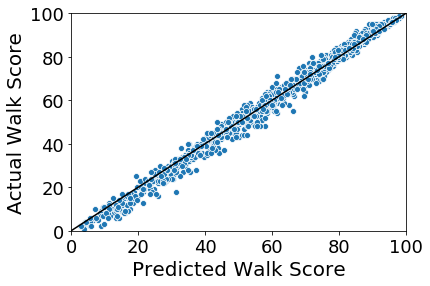

In [31]:
forest_out = forest_grid.predict(Xtrain)
pred_summary(forest_out, ytrain, limit=100)
plt.xlabel('Predicted Walk Score', fontsize = 20); plt.ylabel('Actual Walk Score', fontsize=20);

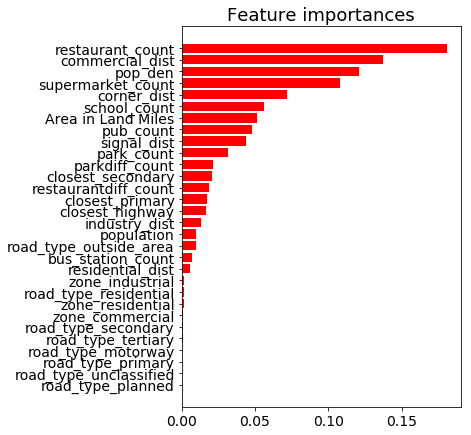

In [32]:
features = X.columns
importance = forest_grid.best_estimator_.feature_importances_
indices = np.argsort(importance)
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], importance[indices],
       color="r",  align="center")
plt.tick_params(labelsize=14);

In [33]:
gbr = GradientBoostingRegressor()

params = {'max_features': [6, 8, 10, 12],
          'n_estimators': [400, 500, 600, 700]}

gbr_grid = RandomizedSearchCV(gbr, params, cv=5, scoring = 'neg_mean_squared_error')

gbr_grid.fit(Xtrain, ytrain)

/Users/perryjohnson/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_features': [6, 8, 10, 12], 'n_estimators': [400, 500, 600, 700]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [34]:
#Best estimator and CV score
print('Best score (RMSE)', np.sqrt(np.abs(gbr_grid.best_score_)))
print(gbr_grid.best_estimator_)

Best score (RMSE) 7.560829541057786
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=6,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)


RMSE 8.987800014280525
R2 0.8651681639883233


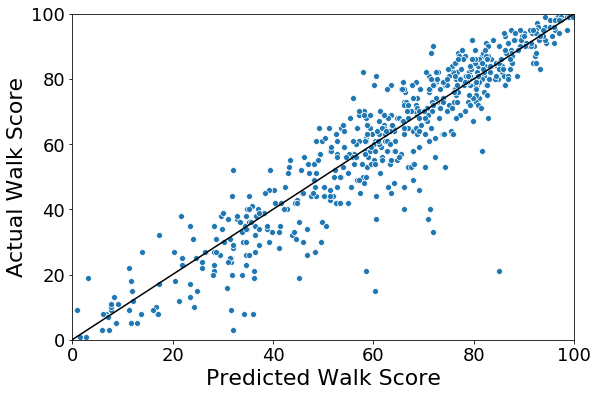

In [35]:
fig = plt.figure(figsize=(9,6))
xgb_out = gbr_grid.predict(Xtest)
pred_summary(xgb_out, ytest, limit=100)
plt.xlabel('Predicted Walk Score', fontsize = 22); plt.ylabel('Actual Walk Score', fontsize=22);